In [21]:
import numpy as np
from scipy import stats

alpha = 0.1                     # допустимая вероятность ошибки I рода
beta = 0.2                      # допустимая вероятность ошибки II рода
mu_control = 2500               # средняя выручка с пользователя в контрольной группе
effect = 150                   # ожидаемый размер эффекта
mu_pilot = mu_control + effect  # средняя выручка с пользователя в экспериментальной группе
std = 800                       # стандартное отклонение

# исторические данные выручки для 10000 клиентов
values = np.random.normal(mu_control, std, 10000)

def estimate_sample_size(effect, std, alpha, beta):
    """Оценка необходимого размер групп."""
    t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    var = 2 * std ** 2
    sample_size = int((t_alpha + t_beta) ** 2 * var / (effect ** 2))
    return sample_size

estimated_std = np.std(values)
sample_size = 1500#estimate_sample_size(effect, estimated_std, alpha, beta)
print(f'оценка необходимого размера групп = {sample_size}')

оценка необходимого размера групп = 1500


In [22]:
def run_synthetic_experiments(values, sample_size, effect=0, n_iter=10000):
    """Проводим синтетические эксперименты, возвращаем список p-value."""
    pvalues = []
    for _ in range(n_iter):
        a, b = np.random.choice(values, size=(2, sample_size,), replace=False)
        b += effect
        pvalue = stats.ttest_ind(a, b).pvalue
        pvalues.append(pvalue)
    return np.array(pvalues)

def print_estimated_errors(pvalues_aa, pvalues_ab, alpha):
    """Оценивает вероятности ошибок."""
    estimated_first_type_error = np.mean(pvalues_aa < alpha)
    estimated_second_type_error = np.mean(pvalues_ab >= alpha)
    ci_first = estimate_ci_bernoulli(estimated_first_type_error, len(pvalues_aa))
    ci_second = estimate_ci_bernoulli(estimated_second_type_error, len(pvalues_ab))
    print(f'оценка вероятности ошибки I рода = {estimated_first_type_error:0.4f}')
    print(f'  доверительный интервал = [{ci_first[0]:0.4f}, {ci_first[1]:0.4f}]')
    print(f'оценка вероятности ошибки II рода = {estimated_second_type_error:0.4f}')
    print(f'  доверительный интервал = [{ci_second[0]:0.4f}, {ci_second[1]:0.4f}]')

def estimate_ci_bernoulli(p, n, alpha=0.05):
    """Доверительный интервал для Бернуллиевской случайной величины."""
    t = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    std_n = np.sqrt(p * (1 - p) / n)
    return p - t * std_n, p + t * std_n

pvalues_aa = run_synthetic_experiments(values, sample_size, effect=0)
pvalues_ab = run_synthetic_experiments(values, sample_size, effect=effect)
print_estimated_errors(pvalues_aa, pvalues_ab, alpha)

оценка вероятности ошибки I рода = 0.1018
  доверительный интервал = [0.0959, 0.1077]
оценка вероятности ошибки II рода = 0.0002
  доверительный интервал = [-0.0001, 0.0005]


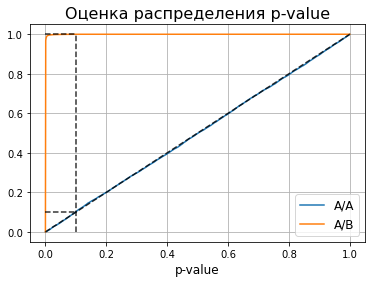

In [23]:
import matplotlib.pyplot as plt

def plot_pvalue_distribution(pvalues_aa, pvalues_ab, alpha, beta):
    """Рисует графики распределения p-value."""
    estimated_first_type_error = np.mean(pvalues_aa < alpha)
    estimated_second_type_error = np.mean(pvalues_ab >= alpha)
    y_one = estimated_first_type_error
    y_two = 1 - estimated_second_type_error
    X = np.linspace(0, 1, 1000)
    Y_aa = [np.mean(pvalues_aa < x) for x in X]
    Y_ab = [np.mean(pvalues_ab < x) for x in X]

    plt.plot(X, Y_aa, label='A/A')
    plt.plot(X, Y_ab, label='A/B')
    plt.plot([alpha, alpha], [0, 1], '--k', alpha=0.8)
    plt.plot([0, alpha], [y_one, y_one], '--k', alpha=0.8)
    plt.plot([0, alpha], [y_two, y_two], '--k', alpha=0.8)
    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)

    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

plot_pvalue_distribution(pvalues_aa, pvalues_ab, alpha, beta)